### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import kornia
import utils.definitions as D

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Dataset

#### a) Data Augmentation

In [2]:
import torchvision.transforms as transforms

train_tf = transforms.Compose([
    transforms.Resize(size=(D.IMAGE_SIZE, D.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize(size=(D.IMAGE_SIZE, D.IMAGE_SIZE)),
    transforms.ToTensor(),
])

#### b) Load dataset

##### CIFAR10

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_tf)
trainloader = DataLoader(trainset, batch_size=D.BATCH_SIZE, shuffle=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=test_tf)
testloader = DataLoader(testset, batch_size=D.BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")

##### CelebA

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA

trainset = CelebA(root='./data', split='train', download=True, transform=train_tf)
trainloader = DataLoader(trainset, batch_size=D.BATCH_SIZE, shuffle=True)

testset = CelebA(root='./data', split='test', download=True, transform=test_tf)
testloader = DataLoader(testset, batch_size=D.BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 162770
Testing samples: 19962


### Create Patches
Create patches from input images

In [19]:
class Patches():
    def __init__(self, patch_size=D.PATCH_SIZE):
        super().__init__()
        self.patch_size = patch_size
        
    def __call__(self, images):
        patches = kornia.contrib.extract_tensor_patches(
            input=images,
            window_size=(self.patch_size, self.patch_size),
            stride=(self.patch_size, self.patch_size),
        )
        
        # (batch, num_patches, channels, patch_height, patch_width)
        return patches
        
    def show_patched_image(self, images, patches):
        """This is a utility function which accepts a batch of images and its corresponding patches and help visualize one image and its patches side by side."""
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(images[idx].permute(1, 2, 0).numpy())
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = patch.permute(1, 2, 0).numpy()
            plt.imshow(patch_img)
            plt.axis("off")
        plt.show()
        
        # Return the index chosen to validate it outside the method.
        return idx
    
    def reconstruct_from_patch(self, patch):
        """Takes the patches from a single image and reconstructs it back into the image"""
        num_patches = patch.shape[0]
        nrows = int(np.sqrt(num_patches))
        
        # View as (batch, patch_height, patch_width, channels)
        patch = patch.permute(0, 2, 3, 1)
        rows = patch.split(nrows, dim=0)
        rows = [torch.cat(torch.unbind(x), dim=1) for x in rows]
        reconstructed = torch.cat(rows, dim=0)
        return reconstructed

Index selected: 251.


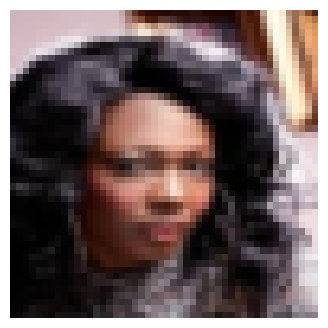

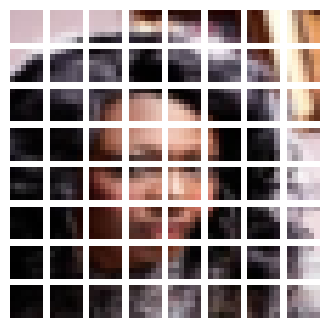

In [20]:
# Get a batch of images.
images, labels = next(iter(trainloader))

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=images)

# Pass the images and its patches to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=images, patches=patches)

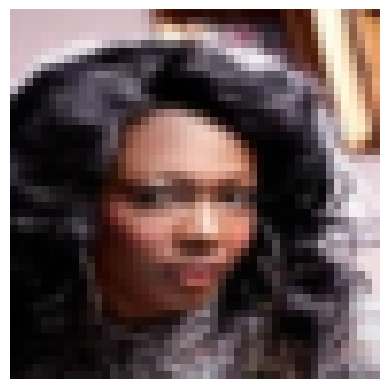

In [21]:
# Get the same image and try reconstructing the patches into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

### Patch Encoder
This layer deals with encoding the patches and adding the positional embedding

In [29]:
class PatchEncoder():
    def __init__(
        self,
        patch_size=D.PATCH_SIZE,
        num_patches=D.NUM_PATCHES,
        projection_dim=D.ENC_PROJECTION_DIM,
        mask_proportion=D.MASK_PROPORTION,
        n_channels=3,
    ):
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.num_mask = int(self.mask_proportion * self.num_patches)
        
        # Create the projection layer for the patches
        in_features = n_channels * patch_size * patch_size
        self.projection = nn.Linear(in_features=in_features, out_features=self.projection_dim)
        
        # Create the positional embedding layer
        self.positional_embedding = nn.Embedding(num_embeddings=self.num_patches, embedding_dim=self.projection_dim)
    
    def __call__(self, patches):
        # View patches as (batch, num_patches, patch_area)
        patches = patches.view(*patches.shape[:2], -1)

        # Get the positional embeddings
        batch_size = patches.shape[0]
        positions = torch.arange(start=0, end=self.num_patches, step=1)
        pos_embeddings = self.positional_embedding(positions[None, :])
        pos_embeddings = torch.tile(pos_embeddings, (batch_size, 1, 1))

        # Embed the patches
        patch_embeddings = (self.projection(patches) + pos_embeddings)
        
        batch_size = patches.shape[0]
        mask_indices, unmask_indices = self.get_random_indices(batch_size)

        # The encoder input is the unmasked patch embeddings. Here we gather all the patches that should be unmasked.
        unmasked_embeddings = self.gather_torch(patch_embeddings, unmask_indices.unsqueeze(2))

        # Get the unmasked and masked position embeddings. We will need them for the decoder.
        unmasked_positions = self.gather_torch(pos_embeddings, unmask_indices.unsqueeze(2))
        masked_positions = self.gather_torch(pos_embeddings, mask_indices.unsqueeze(2))
        
        # Repeat the mask token number of mask times. Mask tokens replace the masks of the image.
        mask_token = torch.normal(size=(1, self.patch_size * self.patch_size * 3), mean=0.0, std=1.0)
        mask_tokens = mask_token.repeat((self.num_mask, 1))
        mask_tokens = mask_tokens.unsqueeze(0).repeat((batch_size, 1, 1))

        masked_embeddings = self.projection(mask_tokens) + masked_positions

        return (
            unmasked_embeddings,    # input to the encoder
            masked_embeddings,      # first part of input to the decoder
            unmasked_positions,     # added to the encoder outputs
            mask_indices,           # the indices that were masked
            unmask_indices,         # the indices that were unmaksed
        )
    
    def get_random_indices(self, batch_size):
        """Create random indices from a uniform distribution and then split it into mask and unmask indices"""
        rand_indices = torch.argsort(
           torch.rand(size=(batch_size, self.num_patches)), dim=-1
        )
        mask_indices = rand_indices[:, :self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]
        return mask_indices, unmask_indices
    
    def show_masked_image(self, patches, unmask_indices):
        # Choose a random patch and its corresponding unmask index
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch
        new_patch = np.zeros_like(patch)

        # Iterate over the new_patch and plug the unmasked patches
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx
    
    @staticmethod
    def gather_torch(params, indices, batch_dim=1):
        """A PyTorch porting of tensorflow.gather_nd by Kulbear https://gist.github.com/Kulbear/b421c32fb64deddfd0403340db4eeeaa
        
        Args:
            params: a tensor of dimension [b1, ..., bn, g1, ..., gm, c].
            indices: a tensor of dimension [b1, ..., bn, x, m]
            batch_dim: indicate how many batch dimension you have, in the above example, batch_dim = n.
        Returns:
            gathered: a tensor of dimension [b1, ..., bn, x, c].
        """
        batch_dims = params.size()[:batch_dim]          # [b1, ..., bn]
        batch_size = np.cumprod(list(batch_dims))[-1]   # b1 * ... * bn
        c_dim = params.size()[-1]                       # c
        grid_dims = params.size()[batch_dim:-1]         # [g1, ..., gm]
        n_indices = indices.size(-2)                    # x
        n_pos = indices.size(-1)                        # m

        # Reshape leading batch dims to a single batch dim
        params = params.reshape(batch_size, *grid_dims, c_dim)
        indices = indices.reshape(batch_size, n_indices, n_pos)

        # Build gather indices
        # Gather for each of the data point in this "batch"
        batch_enumeration = torch.arange(batch_size).unsqueeze(1)
        gather_dims = [indices[:, :, i] for i in range(len(grid_dims))]
        gather_dims.insert(0, batch_enumeration)
        gathered = params[gather_dims]

        # Reshape back to the shape with leading batch dims
        gathered = gathered.reshape(*batch_dims, n_indices, c_dim)
        return gathered

        

In [30]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)

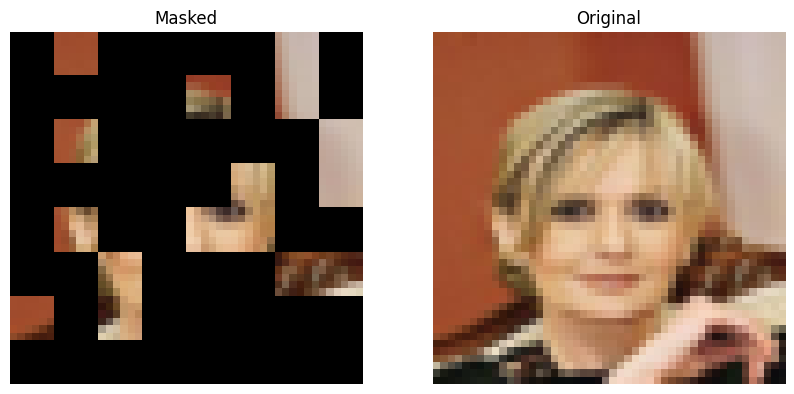

In [31]:
# Show a maksed patch image.
new_patch, random_index = patch_encoder.show_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(torch.from_numpy(new_patch))
plt.imshow(img)
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = images[random_index].permute(1, 2, 0)
plt.imshow(img)
plt.axis("off")
plt.title("Original")
plt.show()

### MLP

In [ ]:
def mlp(x, dropout_rate, hidden_units):
    in_features = x.size(-1)
    for units in hidden_units:
        x = nn.Linear(in_features=in_features, out_features=units)(x)
        x = nn.GELU()(x)
        x = nn.Dropout(p=dropout_rate)(x)
    return x

### MaskedAutoEncoder Model